In [1]:
#importing all the libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

from scipy.spatial.distance import cosine


In [6]:
#using the zip file
from zipfile import ZipFile

zip_file_path = '/content/women-fashion.zip'
extraction_directory = '/content/women_fashion/'

if not os.path.exists(extraction_directory):
  os.makedirs(extraction_directory)

with ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall(extraction_directory)

extracted_files = os.listdir(extraction_directory)
print(extracted_files[:10])

['__MACOSX', 'women fashion']


In [7]:
#lets focus on the 'women fashion' directory and list all the files

#correct the path to include 'women fashion' directory and listin its contents
extraction_directory_updated = os.path.join(extraction_directory,'women fashion')

#list all the files in the updated directory
extracted_files_updated = os.listdir(extraction_directory_updated)
extracted_files_updated[:10], len(extracted_files_updated)


(['fitted dress with a classic black and white houndstooth pattern.webp',
  'black jumpsuit with a diagonal stripe of glittering material running across the body.jpg',
  'shiny purple sequined dress with a one-shoulder design.jpg',
  'black lace bustier top paired with high-waisted black trousers.jpg',
  'bright red, sequined dress with thin shoulder straps.jpg',
  'long, elegant blue dress with an off-the-shoulder design with sheer sleeves.jpg',
  'fitted black dress that reaches down to mid-calf.jpg',
  'anarkali suit. It consists of a turquoise skirt with detailed golden embroidery, a multicolored blouse with floral patterns, and an orange dupatta with lace borders.jpg',
  'black dress with lace detailing.jpg',
  'solid dark blue top and a floral pattern on the bottom.jpg'],
 97)

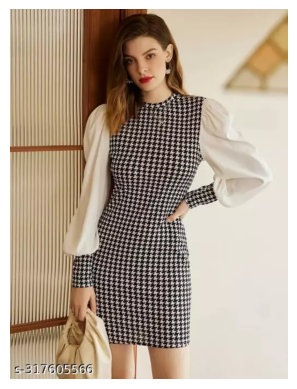

In [8]:
#function to load and display an image
def display_image(file_path):
  image = Image.open(file_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

#display the first image to understand its characteristics
first_image_path = os.path.join(extraction_directory_updated, extracted_files_updated[0])
display_image(first_image_path)

In [9]:
#creating a list of all image file paths that will be used later in extracting the features from every image in the dataset

import glob

#directory path containing your images
image_directory = '/content/women_fashion/women fashion'
image_paths_list = [file for file in glob.glob(os.path.join(image_directory, '*.*')) if file.endswith(('.jpg','.png','.jpeg','.webp'))]


#print the list of image file paths
print(image_paths_list)

['/content/women_fashion/women fashion/fitted dress with a classic black and white houndstooth pattern.webp', '/content/women_fashion/women fashion/black jumpsuit with a diagonal stripe of glittering material running across the body.jpg', '/content/women_fashion/women fashion/shiny purple sequined dress with a one-shoulder design.jpg', '/content/women_fashion/women fashion/black lace bustier top paired with high-waisted black trousers.jpg', '/content/women_fashion/women fashion/bright red, sequined dress with thin shoulder straps.jpg', '/content/women_fashion/women fashion/long, elegant blue dress with an off-the-shoulder design with sheer sleeves.jpg', '/content/women_fashion/women fashion/fitted black dress that reaches down to mid-calf.jpg', '/content/women_fashion/women fashion/anarkali suit. It consists of a turquoise skirt with detailed golden embroidery, a multicolored blouse with floral patterns, and an orange dupatta with lace borders.jpg', '/content/women_fashion/women fashio

In [10]:
#now creating the model

base_model = VGG16(weights='imagenet', include_top=False) #base pretrained vgg16 model excluding the top layers
model = Model(inputs=base_model.input, outputs=base_model.output) #loading the model in model variable


#function to  preprocess the image
def preprocess_image(img_path):
  img = image.load_img(img_path,target_size=(224,224)) #load the image
  img_array = image.img_to_array(img)   #converting the image to array using image.img_to_array()
  img_array_expanded = np.expand_dims(img_array,axis=0)   #expanding the dimensions of the array
  return preprocess_input(img_array_expanded)   #returning the expanded array with preprocessed_input(for vgg16)


#function to extract the features
def extract_features(model, preprocessed_img):
  features = model.predict(preprocessed_img) #prediction
  flattened_features = features.flatten() #flattening
  normalized_features = flattened_features/np.linalg.norm(flattened_features) #calculating the  L2 normalized features(feature/sq root of square of features) by using numpy's linear algebra mod
  return normalized_features

#creating list of features and image names
all_features = []
all_image_names = []

#running the model
for img_path in image_paths_list:
  preprocessed_img = preprocess_image(img_path)
  features = extract_features(model,preprocessed_img)
  all_features.append(features)
  all_image_names.append(os.path.basename(img_path))



1/1 [==============================] - 0s 364ms/step


In [11]:
#function to recommend fashion images based on image features

from scipy.spatial.distance import cosine

def recommend_fashion_items_cnn(input_image_path, all_features, all_image_names,model, top_n=5):
  #preprocess the input image and extract features
  preprocessed_img = preprocess_image(input_image_path)
  input_features = extract_features(model,preprocessed_img)

  #calculate similarities and find the top N similar images
  similarities = [1-cosine(input_features,other_feature) for other_feature in all_features]
  similar_indices = np.argsort(similarities)[-top_n:]

  #filtering out the input image index from similar indices
  similar_indices = [idx for idx in similar_indices if idx!= all_image_names.index(input_image_path)]


  #display the input image
  plt.figure(figsize=(15,10))
  plt.subplot(1,top_n+1,1)
  plt.imshow(Image.open(input_image_path))
  plt.title("Input Image")
  plt.axis('off')

  #display similar images
  for i, idx in enumerate(similar_indices[:top_n],start=1):
    image_path = os.path.join('/content/women_fashion/women fashion', all_image_names[idx])
    plt.subplot(1,top_n+1,i+1)
    plt.imshow(Image.open(image_path))
    plt.title(f"Recommendation {i}")
    plt.axis('off')

  plt.tight_layout()
  plt.show()


1/1 [==============================] - 0s 381ms/step


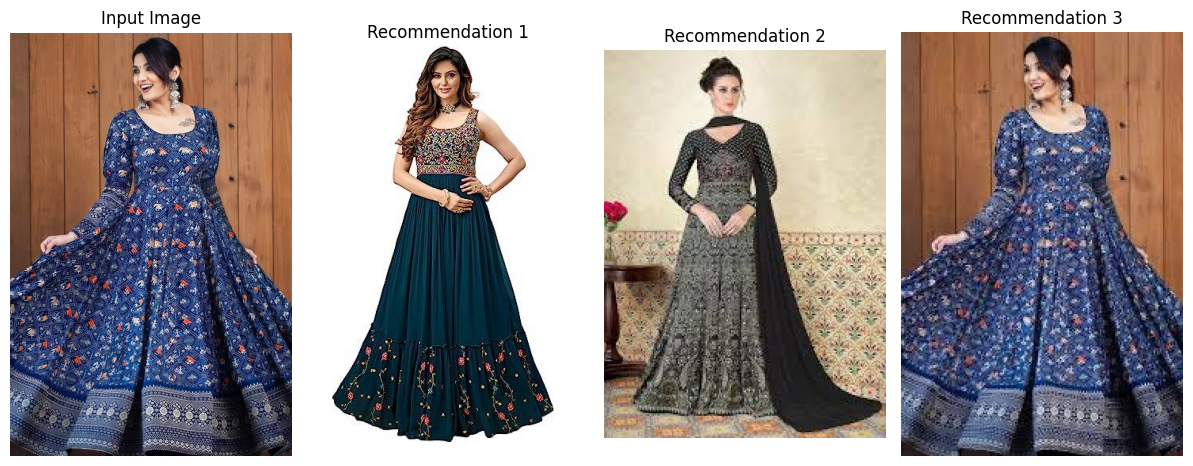

In [12]:
#implementtion
#enter the image file path
input_image_path = '/content/women_fashion/women fashion/Latest-Party-Wear-One-Piece-Gown-For-Women.webp'
recommend_fashion_items_cnn(input_image_path, all_features, image_paths_list, model, top_n = 4)